In [2]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import functools
import math
import livelossplot
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from Utils.helper import *
from Utils.sample_squads import *

In [3]:
thresh = 3
def my_autopct(pct):
    return ('%.2f' % pct) if pct >= thresh else ''

In [4]:
model_inn_1 = tf.keras.models.load_model('Models\Inn1-HeavyDense-ep20to50\cp-0029.h5')
model_inn_2 = tf.keras.models.load_model('Models\Inn2-HeavyDenseRequired-ep30to50\cp-0016.h5')

## Innings 1

In [15]:
inn1_df = pd.DataFrame(columns=BF_Cols)
inn1 = Innings(RCB_Squad[0], CSK_Squad[1], CSK_Squad[0][0], RCB_Pitch, 1, inn1_df)
target = inn1.simulate_inning(model_inn_1)
display_batting_table(inn1)

Royal Challengers Bangalore  :  168 / 7  in  20 . 0
Extras: 13



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,7,1,0,8,Caught,DL Chahar
1,V Kohli,77,5,4,52,Bowled,SN Thakur
2,AB de Villiers,13,2,0,12,Caught,Imran Tahir
3,M Ali,6,0,0,12,Caught,RA Jadeja
4,S Hetmyer,29,3,0,24,Caught,DJ Bravo
5,S Dube,14,3,0,6,Caught,DL Chahar
6,C de Grandhomme,7,0,1,4,Bowled,DJ Bravo
7,N Saini,1,0,0,1,Not Out,-
8,YS Chahal,1,0,0,1,Not Out,-
9,UT Yadav,-,-,-,-,-,-


,Bowler,Runs Conceded,Wickets Taken,Overs,Batsman Names
0,DL Chahar,22,2,4.0,"PA Patel, S Dube"
1,SN Thakur,32,1,4.0,V Kohli
2,RA Jadeja,40,1,4.0,M Ali
3,Imran Tahir,25,1,4.0,AB de Villiers
4,DJ Bravo,44,2,4.0,"S Hetmyer, C de Grandhomme"


,Dismissed Batsman,Team Runs,Overs
0,PA Patel,10,3
2,AB de Villiers,54,8
3,M Ali,80,11
1,V Kohli,135,17
5,S Dube,154,19
4,S Hetmyer,158,20
6,C de Grandhomme,164,20


,Over,Bowler,Runs Conceded,Wickets Taken,Total Score,Total Wickets
0,1,DL Chahar,6,0,6,0
1,2,SN Thakur,4,0,10,0
2,3,DL Chahar,6,1,16,1
3,4,SN Thakur,10,0,26,1
4,5,DL Chahar,3,0,29,1
5,6,SN Thakur,12,0,41,1
6,7,RA Jadeja,13,0,54,1
7,8,Imran Tahir,4,1,58,2
8,9,RA Jadeja,13,0,71,2
9,10,Imran Tahir,4,0,75,2


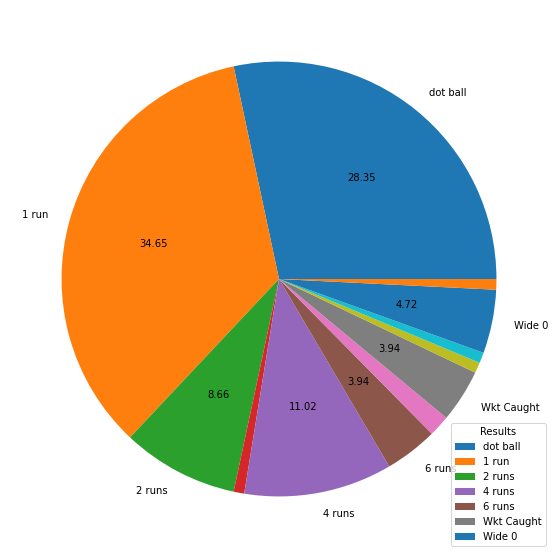

In [18]:
res_dist = {}
tot = inn1.inn_progress_df.shape[0]
for res in (inn1.inn_progress_df["result"]):
    if res in res_dist:
        res_dist[res] += 1
    else:
        res_dist[res] = 1
labels = [res_to_string[i] if res_dist[i]/tot*100 >= thresh else ''
          for i in sorted(res_dist)]
plt.pie([res_dist[i] for i in sorted(res_dist)], labels=labels, autopct=my_autopct)
plt.legend(title = "Results")
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

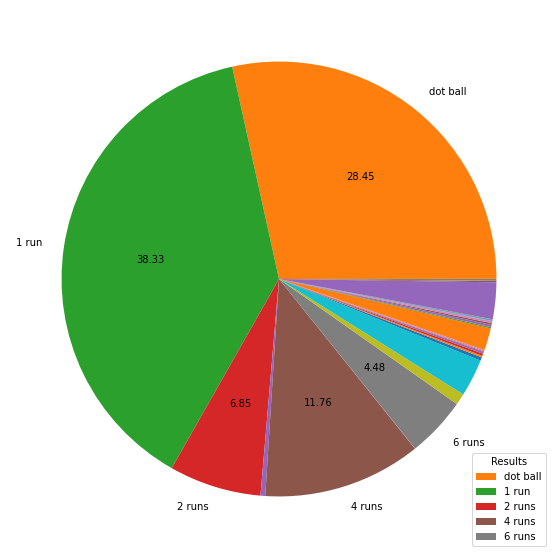

In [19]:
res_dist = {}
score = target - 1
start_score = score - 10
end_score = score + 10
df = batting_first[batting_first["Total"] >= start_score]
df = df[df["Total"] <= end_score]
tot = df.shape[0]
for res in (df["Result"]):
    if res in res_dist:
        res_dist[res] += 1
    else:
        res_dist[res] = 1
labels = [res_to_string[i] if res_dist[i]/tot*100 >= thresh else ''
          for i in sorted(res_dist)]
plt.pie([res_dist[i] for i in sorted(res_dist)], labels=labels, autopct=my_autopct)
plt.legend(title = "Results")
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()


In [5]:
chasing = pd.read_csv("Data/Chasing.csv")
ret_chasing = []
prev = tuple([None for i in range(5)])
for ind, row in tqdm(chasing.iterrows(), ncols=80, total=chasing.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"], row["Target"])
    if prev != curr:
        ret_chasing.append(curr)
    prev = curr
batting_first = pd.read_csv("Data/Batting_First.csv")
ret_batting_first = []
prev = tuple([None for i in range(4)])
for ind, row in tqdm(batting_first.iterrows(), ncols=80, total=batting_first.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"])
    if prev != curr:
        ret_batting_first.append(curr)
    prev = curr
print(len(ret_chasing), len(ret_batting_first))

100%|██████████████████████████████████| 98040/98040 [00:06<00:00, 14960.79it/s]

795 797


In [6]:
bf_count = 0
bs_count = 0
total = []
while bf_count < len(ret_batting_first) and bs_count < len(ret_chasing):
    i = ret_batting_first[bf_count]
    j = ret_chasing[bs_count]
    if i[0] == j[0] and i[1] == j[2] and i[2] == j[1] and i[3] == j[3]:
        bf_count += 1
        bs_count += 1
        total.append(j[4] - 1)
    else:
        bf_count += 1
        total.append(-1)
print(bf_count, bs_count)
target_col = []
prev = None
match_count = -1
for ind, row in tqdm(batting_first.iterrows(), ncols=80, total=batting_first.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"])
    if prev != curr:
        match_count += 1
    target_col.append(total[match_count])
    prev = curr
batting_first["Total"] = target_col

797 795


100%|██████████████████████████████████| 98040/98040 [00:06<00:00, 16090.75it/s]


## Innings 2

In [12]:
for _ in range(10):
    inn2_df = pd.DataFrame(columns=BS_Cols)
    inn2 = Innings(CSK_Squad[0], RCB_Squad[1], RCB_Squad[0][0], CSK_Pitch, 2, inn2_df, 179)
    # inn2 = Innings(RCB_Squad[0], CSK_Squad[1], CSK_Squad[0][0], CSK_Pitch, 2, inn2_df, 209)
    inn2.simulate_inning(model_inn_2)
    display_batting_table(inn2, 0)

Chennai Super Kings  :  182 / 3  in  19 . 1
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,8,1,0,7,Caught,Mohammed Siraj
1,F du Plessis,32,5,0,35,Caught,N Saini
2,SK Raina,82,8,4,46,Caught,Mohammed Siraj
3,AT Rayudu,48,4,3,26,Not Out,-
4,KM Jadhav,1,0,0,1,Not Out,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  160 / 7  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,16,2,1,11,Caught,UT Yadav
1,F du Plessis,25,4,0,27,Run Out,-
2,SK Raina,30,3,1,24,Caught,N Saini
3,AT Rayudu,4,1,0,4,Caught,N Saini
4,KM Jadhav,7,1,0,5,Caught,YS Chahal
5,MS Dhoni,0,0,0,1,Caught,YS Chahal
6,RA Jadeja,38,2,2,22,Not Out,-
7,DJ Bravo,15,2,1,7,Retired Hurt,-
8,SN Thakur,17,1,0,19,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  180 / 8  in  19 . 3
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,39,4,2,23,Run Out,-
1,F du Plessis,10,1,0,12,Caught,C de Grandhomme
2,SK Raina,5,0,0,7,Caught,YS Chahal
3,AT Rayudu,18,2,0,15,Run Out,-
4,KM Jadhav,28,3,0,23,Caught,N Saini
5,MS Dhoni,29,0,3,16,Caught,N Saini
6,RA Jadeja,5,1,0,4,Caught,UT Yadav
7,DJ Bravo,13,1,0,7,Caught,Mohammed Siraj
8,SN Thakur,22,4,0,10,Not Out,-
9,DL Chahar,6,0,1,1,Not Out,-



Chennai Super Kings  :  139 / 2  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,83,7,3,61,Not Out,-
1,F du Plessis,1,0,0,7,Caught,Mohammed Siraj
2,SK Raina,25,3,0,30,Caught,YS Chahal
3,AT Rayudu,23,0,0,22,Not Out,-
4,KM Jadhav,-,-,-,-,-,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  180 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,87,8,5,55,Bowled,UT Yadav
1,F du Plessis,0,0,0,2,Caught,Mohammed Siraj
2,SK Raina,23,2,1,12,Caught,N Saini
3,AT Rayudu,13,0,2,7,Run Out,-
4,KM Jadhav,35,3,1,33,Caught,C de Grandhomme
5,MS Dhoni,11,1,0,9,Not Out,-
6,RA Jadeja,2,0,0,1,Not Out,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  165 / 7  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,1,0,0,2,Caught,UT Yadav
1,F du Plessis,9,1,0,15,Caught,UT Yadav
2,SK Raina,39,4,1,37,Caught,N Saini
3,AT Rayudu,16,2,0,13,Bowled,YS Chahal
4,KM Jadhav,13,3,0,5,Caught,N Saini
5,MS Dhoni,54,6,2,29,Caught,UT Yadav
6,RA Jadeja,4,1,0,2,Caught,C de Grandhomme
7,DJ Bravo,16,3,0,11,Not Out,-
8,SN Thakur,9,1,0,6,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  170 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,6,1,0,8,Caught,UT Yadav
1,F du Plessis,15,2,0,16,Caught,N Saini
2,SK Raina,16,2,1,9,Caught,UT Yadav
3,AT Rayudu,9,1,0,7,Caught,C de Grandhomme
4,KM Jadhav,3,0,0,7,Bowled,N Saini
5,MS Dhoni,50,3,2,38,Not Out,-
6,RA Jadeja,64,7,2,35,Not Out,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  181 / 4  in  17 . 3
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,8,1,0,6,Bowled,UT Yadav
1,F du Plessis,36,5,1,21,LBW,C de Grandhomme
2,SK Raina,92,10,4,49,Caught,C de Grandhomme
3,AT Rayudu,19,1,2,15,Caught,N Saini
4,KM Jadhav,16,3,0,15,Not Out,-
5,MS Dhoni,1,0,0,2,Not Out,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  155 / 6  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,7,1,0,7,Caught,Mohammed Siraj
1,F du Plessis,4,0,0,10,Bowled,UT Yadav
2,SK Raina,16,1,1,15,Caught,C de Grandhomme
3,AT Rayudu,49,5,2,30,Caught,C de Grandhomme
4,KM Jadhav,44,2,2,36,Not Out,-
5,MS Dhoni,0,0,0,1,Caught,C de Grandhomme
6,RA Jadeja,21,1,1,15,Caught,Mohammed Siraj
7,DJ Bravo,6,0,0,6,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  164 / 7  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,45,7,0,35,Caught,YS Chahal
1,F du Plessis,26,2,1,23,Caught,N Saini
2,SK Raina,0,0,0,0,Run Out,-
3,AT Rayudu,17,2,1,9,LBW,N Saini
4,KM Jadhav,12,0,1,9,Caught,C de Grandhomme
5,MS Dhoni,42,5,1,28,Caught,UT Yadav
6,RA Jadeja,11,1,0,12,Caught,UT Yadav
7,DJ Bravo,1,0,0,1,Not Out,-
8,SN Thakur,5,1,0,3,Not Out,-
9,DL Chahar,-,-,-,-,-,-


## Simulating Matches

In [30]:
print("Simulating First Match")
match_sim2 = Match(RCB_Squad, MI_Squad, RCB_Pitch, model_inn_1, model_inn_2, Display=1)

Simulating First Match
Royal Challengers Bangalore won the toss and chose to Bat first
Royal Challengers Bangalore  :  174 / 7  in  20 . 0
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,100,5,7,62,Bowled,SL Malinga
1,V Kohli,5,1,0,8,LBW,SL Malinga
2,AB de Villiers,2,0,0,6,Caught,SL Malinga
3,M Ali,2,0,0,5,Caught,JJ Bumrah
4,S Hetmyer,17,1,0,19,Caught,SL Malinga
5,S Dube,10,2,0,6,Caught,J Behrendorff
6,C de Grandhomme,16,0,1,10,Not Out,-
7,N Saini,2,0,0,2,Caught,JJ Bumrah
8,YS Chahal,6,1,0,4,Not Out,-
9,UT Yadav,-,-,-,-,-,-



Mumbai Indians  :  151 / 5  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,39,8,0,19,Run Out,-
1,RG Sharma,24,1,0,32,Caught,Mohammed Siraj
2,SA Yadav,59,5,3,34,Bowled,N Saini
3,Ishan Kishan,1,0,0,2,Bowled,Mohammed Siraj
4,HH Pandya,12,0,0,21,Not Out,-
5,KA Pollard,7,1,0,7,LBW,UT Yadav
6,KH Pandya,3,0,0,6,Not Out,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Royal Challengers Bangalore won by 23 Runs
